# Práctica 3: Clasificación jerárquica

## **Objetivo**: El objetivo de esta práctica es introducir los conceptos de clasificación jerárquica

La práctica se ha realizado siguiendo la opción siguiente:

**OPCIÓN 2: Comparación de métodos**

Seleccione al menos dos algoritmos de los disponibles en la bibliotecas indicadas. Seleccione al menos tres problemas
de clasificación jerárquica de los repositorios indicados.
Realice las siguientes tareas:
1. Aplique los algoritmos seleccionados a los datasets
2. Compare los resultados y explique qué conclusiones se podrían obtener

In [21]:
# Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
import arff

from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, multi_labeled
from sklearn.preprocessing import LabelEncoder

In [22]:
# Establecer semilla para reproducibilidad
SEED = 751
np.random.seed(SEED)

rng = np.random.RandomState(SEED)

### Preparación de datos

Se van a utilizar los datasets facilitados en las diapositivas del tema de clasificación jerárquica:
- [TEsHierarchicaldatasets](https://github.com/geantrindade/TEsHierarchicalDatasets)
    - repbase
    - mips
- [lshtc](https://www.kaggle.com/competitions/lshtc/data): Large Scale Hierarchical Text Classification (LSHTC) Challenge.  El LSHTC Challenge es una competición de clasificación de textos jerárquicos que utiliza conjuntos de datos muy grandes.
    - train - Training set
    - test - Test set
    - hierarchy - Wikipedia hierarchy
    - AllZerosBenchmark - example submission file
    - knn-baseline - A simple flat kNN baseline
    - train-remapped, test-remapped - Training and Test sets reformatted per this forum thread



Que son dos datasets preparados para aplicar clasificación jerárquica.

### TEsHierarchicalDatasets

#### MIPS

In [20]:
train_data_path = "TEsHierarchicalDatasets/TEsHierarchicalDatasets-master/arff/mips1trainatt.arff"
test_data_path = "TEsHierarchicalDatasets/TEsHierarchicalDatasets-master/arff/mips1testatt.arff"

# Cargar los datos de entrenamiento y prueba
train_MIPS = arff.load(open(train_data_path, 'r'))
test_MIPS = arff.load(open(test_data_path, 'r'))

### REPBASE

In [16]:
train_data_path = "TEsHierarchicalDatasets/TEsHierarchicalDatasets-master/arff/repbase1trainatt.arff"
test_data_path = "TEsHierarchicalDatasets/TEsHierarchicalDatasets-master/arff/repbase1testatt.arff"

# Cargar los datos de entrenamiento y prueba
train_REPBASE = arff.load(open(train_data_path, 'r'))
test_REPBASE = arff.load(open(test_data_path, 'r'))

In [49]:
# Extraer la jerarquía de clases
hierarchical_column_index = -1
hierarchical_column_name, hierarchy_values = train_MIPS['attributes'][hierarchical_column_index]

# Construir la jerarquía
class_hierarchy = {ROOT: hierarchy_values}

In [50]:
class_hierarchy

{'<ROOT>': ['1',
  '1/1',
  '1/1/1',
  '1/1/2',
  '1/4',
  '1/5',
  '2',
  '2/1',
  '2/1/1',
  '2/1/1/1',
  '2/1/1/2',
  '2/1/1/3',
  '2/1/1/8',
  '2/1/1/9']}

In [84]:
def convert_to_new_hierarchy(old_hierarchy):
    new_hierarchy = {}
    root_key = "<ROOT>"
    
    for key, values in old_hierarchy.items():
        key = key
        values = values
    
    for value in values:
        value = value.split('/')

        if len(value) == 1:
            # Añadir a la key el valor junto a los que ya habia para esa key
            new_hierarchy[key] = new_hierarchy.get(key, []) + [value[0]]
        elif len(value) == 2:
            # Añadir a la key el valor junto a los que ya habia para esa key
            new_hierarchy[value[0]] = new_hierarchy.get(value[0], []) + [value[1]]
        elif len(value) == 3:
            # Añadir a la key el valor junto a los que ya habia para esa key
            # new_hierarchy[value[1]] = new_hierarchy.get(value[1], []) + [value[2]]
        '''elif len(value) == 4:
            # Añadir a la key el valor junto a los que ya habia para esa key
            new_hierarchy[key] = new_hierarchy.get(key, []) + [value[0]]
            # Añadir a la key el valor junto a los que ya habia para esa key
            new_hierarchy[value[0]] = new_hierarchy.get(value[0], []) + [value[1]]
            # Añadir a la key el valor junto a los que ya habia para esa key
            new_hierarchy[value[1]] = new_hierarchy.get(value[1], []) + [value[2]]
            # Añadir a la key el valor junto a los que ya habia para esa key
            new_hierarchy[value[2]] = new_hierarchy.get(value[2], []) + [value[3]]
        elif len(value) == 5:
            # Añadir a la key el valor junto a los que ya habia para esa key
            new_hierarchy[key] = new_hierarchy.get(key, []) + [value[0]]
            # Añadir a la key el valor junto a los que ya habia para esa key
            new_hierarchy[value[0]] = new_hierarchy.get(value[0], []) + [value[1]]
            # Añadir a la key el valor junto a los que ya habia para esa key
            new_hierarchy[value[1]] = new_hierarchy.get(value[1], []) + [value[2]]
            # Añadir a la key el valor junto a los que ya habia para esa key
            new_hierarchy[value[2]] = new_hierarchy.get(value[2], []) + [value[3]]
            # Añadir a la key el valor junto a los que ya habia para esa key
            new_hierarchy[value[3]] = new_hierarchy.get(value[3], []) + [value[4]]'''
    
    return new_hierarchy

new_hierarchy = convert_to_new_hierarchy(class_hierarchy)
print(new_hierarchy)

{'<ROOT>': ['1', '2'], '1': ['1', '1', '2', '4', '5', '1'], '2': ['1']}


In [64]:
new_hierarchy = convert_to_new_hierarchy(class_hierarchy)
print(new_hierarchy)

{'<ROOT>': {}}


In [48]:


# Convertir las etiquetas de entrenamiento a representación numérica
le = LabelEncoder()
y_train = le.fit_transform([str(label) for label in train_MIPS['data'][hierarchical_column_index]])

# Obtener las etiquetas únicas en el conjunto de entrenamiento
unique_labels_train = set(map(str, train_MIPS['data'][hierarchical_column_index]))

# Convertir las etiquetas de prueba a representación numérica, ignorando las no vistas durante el ajuste
y_test = le.transform([str(label) for label in test_MIPS['data'][hierarchical_column_index] if str(label) in unique_labels_train])

# Eliminar la columna de jerarquía de los datos
X_train = [row[:-1] for row in train_MIPS['data']]
X_test = [row[:-1] for row in test_MIPS['data']]

TypeError: list indices must be integers or slices, not str

In [47]:
print(len(X_train), len(y_train))

16805 337


In [42]:
# Construir el clasificador jerárquico
base_estimator = make_pipeline(
    TruncatedSVD(n_components=24),
    svm.SVC(gamma=0.001, kernel="rbf", probability=True),
)

clf = HierarchicalClassifier(
    base_estimator=base_estimator,
    class_hierarchy=class_hierarchy,
)

In [44]:
# Ajustar el clasificador jerárquico
clf.fit(X_train, y_train)

# Predecir las etiquetas en el conjunto de prueba
y_pred = clf.predict(X_test)

# Imprimir el informe de clasificación
print("Classification Report:\n", classification_report(y_test, y_pred))

# Demostrar el uso de nuestras métricas jerárquicas con el envoltorio MLB
with multi_labeled(y_test, y_pred, clf.graph_) as (y_test_, y_pred_, graph_):
    h_fbeta = h_fbeta_score(
        y_test_,
        y_pred_,
        graph_,
    )
    print("h_fbeta_score: ", h_fbeta)

ValueError: Found input variables with inconsistent numbers of samples: [16805, 337]

In [40]:


# Imprimir el informe de clasificación
print("Classification Report:\n", classification_report(y_test, y_pred))

# Demostrar el uso de nuestras métricas jerárquicas con el envoltorio MLB
with multi_labeled(y_test, y_pred, clf.graph_) as (y_test_, y_pred_, graph_):
    h_fbeta = h_fbeta_score(
        y_test_,
        y_pred_,
        graph_,
    )
    print("h_fbeta_score: ", h_fbeta)

ValueError: Found input variables with inconsistent numbers of samples: [16805, 337]

train_MIPS

### LSHTC

Al tener los conjuntos de datos diferentes estructuras, se va a proceder a realizar la clasificación por separado, empezando por al dataset lshtc

In [25]:
# Ruta del archivo de prueba
test_path = 'lshtc/test-remapped/test-remapped.csv'

with open(test_path, 'r') as test_file:
    test_lines = test_file.readlines()

# Borrar la primera línea de cabecera
test_lines.pop(0)

# Crear un DataFrame para almacenar los datos de prueba
data_test = {'Id': [], 'Data': []}

for line in test_lines:
    parts = line.strip().split(',')
    data_test['Id'].append(int(parts[0]))
    data_test['Data'].append(parts[1])

# Convertir el diccionario a un DataFrame
df_test = pd.DataFrame(data_test)

In [ ]:
g

In [24]:
# Dataset Iris
Iris_X, Iris_Y = datasets.load_iris(return_X_y=True)

# Dataset Wine
Wine_X, Wine_Y = datasets.load_wine(return_X_y=True)

# Dataset Breast Cancer
BreastCancer_X, BreastCancer_Y = datasets.load_breast_cancer(return_X_y=True)

Vamos a visualizar el dataset con un código encontrado en la [propia documentación de la librería scikit](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)

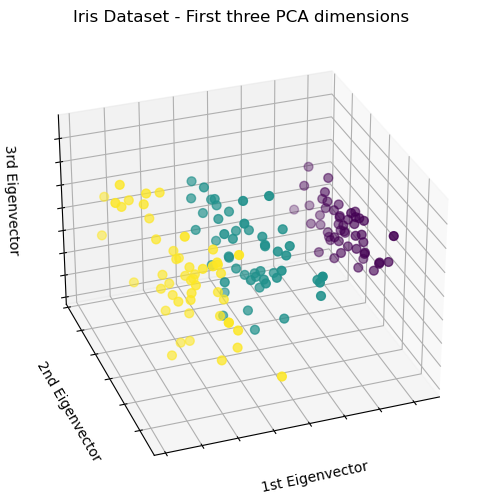

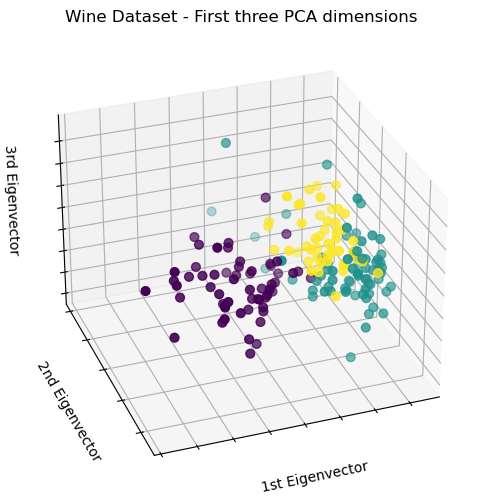

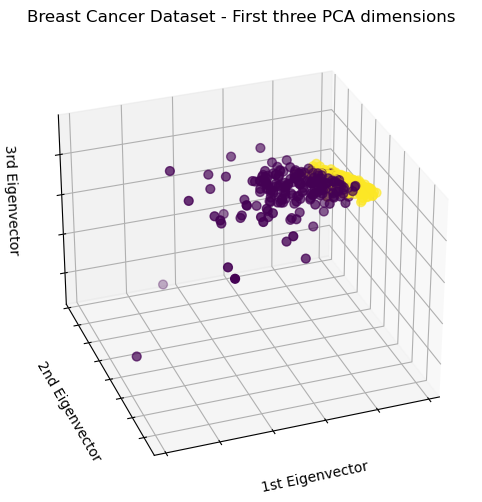

In [25]:
# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn.decomposition import PCA

def plot_dataset(X, Y, Title = ""):

    fig = plt.figure(1, figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

    X_reduced = PCA(n_components=3).fit_transform(X)
    ax.scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        X_reduced[:, 2],
        c=Y,
        s=40,
    )

    ax.set_title(Title)
    ax.set_xlabel("1st Eigenvector")
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel("2nd Eigenvector")
    ax.yaxis.set_ticklabels([])
    ax.set_zlabel("3rd Eigenvector")
    ax.zaxis.set_ticklabels([])

    plt.show()

# Iris Dataset
plot_dataset(Iris_X, Iris_Y, "Iris Dataset - First three PCA dimensions")

# Wine Dataset
plot_dataset(Wine_X, Wine_Y, "Wine Dataset - First three PCA dimensions")

# Breast Cancer Dataset
plot_dataset(BreastCancer_X, BreastCancer_Y, "Breast Cancer Dataset - First three PCA dimensions")

Queremos tratar un problema de aprendizaje semi-supervisado pero la forma que hemos utilizado para tener los conjuntos de datos de scikit nos los da para un problema supervisado. Por eso se debe simular un conjunto de datos semi-supervisado como indicaba la nota de la práctica, eliminando etiquetas de un porcentaje de instancias

In [26]:
SEMISUPERVISED_ELIMINATE = 0.3

In [27]:
# Dataset Iris
mask_unlabeled = rng.rand(len(Iris_Y)) < SEMISUPERVISED_ELIMINATE # Eliminación de un 30% de las etiquetas
Iris_Y[mask_unlabeled] = -1

# Dataset BreastCancer
mask_unlabeled = rng.rand(len(Wine_Y)) < SEMISUPERVISED_ELIMINATE # Eliminación de un 30% de las etiquetas
Wine_Y[mask_unlabeled] = -1

# Dataset Breast Cancer
mask_unlabeled = rng.rand(len(BreastCancer_Y)) < SEMISUPERVISED_ELIMINATE # Eliminación de un 30% de las etiquetas
BreastCancer_Y[mask_unlabeled] = -1

Ya tenemos el conjunto de datos preparado para aprendizaje semi-supervisado. Pero tenemos el conjunto de datos completo. Al estar trabajando y simulando problemas de *machine learning* debemos realizar una división del dataset en los subconjuntos:
- Train
- Validación
- Test

Pero al estar haciendo simulaciones sólo realizaremos la división en los conjuntos de Train y Test. Normalmente cuando se dividen entre estos subconjuntos la división suele ser del 70-30 o del 80-20. Vamos a probar con un 70-30.

In [28]:
# Dataset Iris
Iris_X_train, Iris_X_test, Iris_Y_train, Iris_Y_test = train_test_split(Iris_X, Iris_Y, test_size=0.3, random_state=SEED)

# Dataset Wine
Wine_X_train, Wine_X_test, Wine_Y_train, Wine_Y_test = train_test_split(Wine_X, Wine_Y, test_size=0.3, random_state=SEED)

# Dataset Breast Cancer
BreastCancer_X_train, BreastCancer_X_test, BreastCancer_Y_train, BreastCancer_Y_test = train_test_split(BreastCancer_X, BreastCancer_Y, test_size=0.3, random_state=SEED)

Se normalizan los datos

In [29]:
# Dataset Iris
scaler = StandardScaler()
X_train = scaler.fit_transform(Iris_X_train)
X_test = scaler.transform(Iris_X_test)

# Dataset Wine
scaler = StandardScaler()
X_train = scaler.fit_transform(Wine_X_train)
X_test = scaler.transform(Wine_X_test)

# Dataset Breast Cancer
scaler = StandardScaler()
X_train = scaler.fit_transform(BreastCancer_X_train)
X_test = scaler.transform(BreastCancer_X_test)

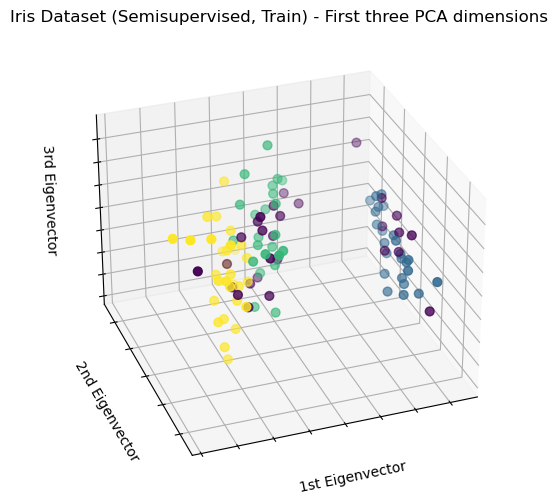

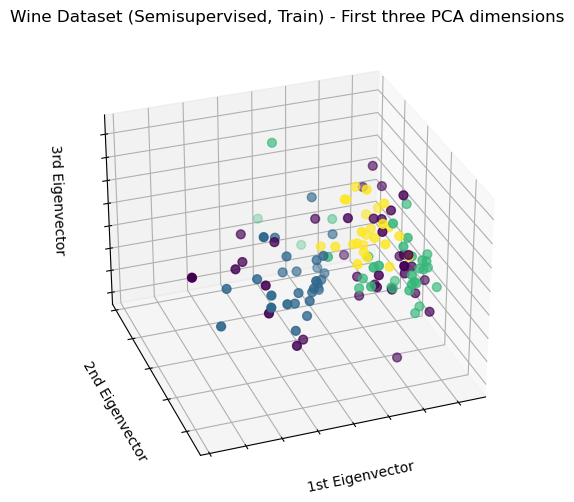

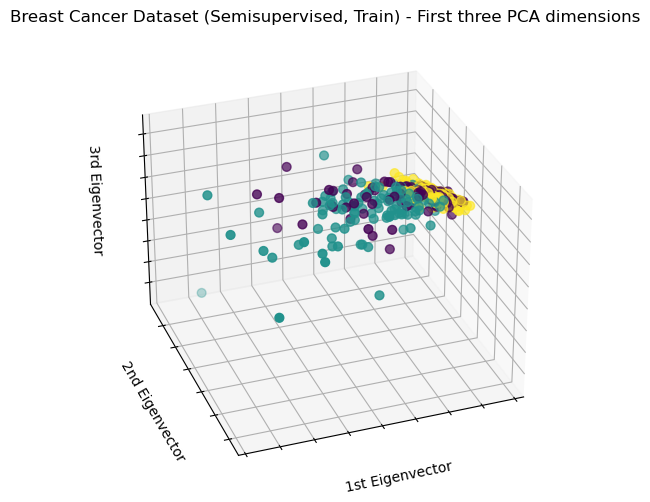

In [30]:
# Iris Dataset
plot_dataset(Iris_X_train, Iris_Y_train, "Iris Dataset (Semisupervised, Train) - First three PCA dimensions")

# Wine Dataset
plot_dataset(Wine_X_train, Wine_Y_train, "Wine Dataset (Semisupervised, Train) - First three PCA dimensions")

# Breast Cancer Dataset
plot_dataset(BreastCancer_X_train, BreastCancer_Y_train, "Breast Cancer Dataset (Semisupervised, Train) - First three PCA dimensions")

Scikit tiene dos algoritmos semi-supervisados ya implementados según la [documentación](https://scikit-learn.org/stable/modules/semi_supervised.html). Así que se usaran estos dos algoritmos:
- Self Training
- Label Propagation

Pero además, revisando los algoritmos implementados en el módulo de semi_supervised hemos encontrado el algoritmo LabelSpreading, así que usaremos estos 3 algoritmos.

Según la documentación Label Propagation y Label Spreading se basan en lo mismo pero: *LabelPropagation and LabelSpreading differ in modifications to the similarity matrix that graph and the clamping effect on the label distributions. Clamping allows the algorithm to change the weight of the true ground labeled data to some degree. The LabelPropagation algorithm performs hard clamping of input labels, which means alpha=0. This clamping factor can be relaxed, to say alpha = 0.2, which means that we will always retain 80 percent of our original label distribution, but the algorithm gets to change its confidence of the distribution within 20 percent.*

In [31]:
# Self Training
svc = SVC(probability=True, gamma="auto")
Iris_self_training_model = SelfTrainingClassifier(svc)
Wine_self_training_model = SelfTrainingClassifier(svc)
BreastCancer_self_training_model = SelfTrainingClassifier(svc)

# Label Propagation
Iris_lp = LabelPropagation(kernel='knn', n_neighbors=7)
Wine_lp = LabelPropagation(kernel='knn', n_neighbors=7)
BreastCancer_lp = LabelPropagation(kernel='knn', n_neighbors=7)

# Label Spreading
Iris_ls = LabelSpreading(kernel='rbf', gamma=0.25)
Wine_ls = LabelSpreading(kernel='rbf', gamma=0.25)
BreastCancer_ls = LabelSpreading(kernel='rbf', gamma=0.25)

### Parte 1: Aplicar algoritmos

Y ahora aplicamos los algoritmos a cada conjunto de datos

In [32]:
# Dataset Iris
Iris_self_training_model.fit(Iris_X_train, Iris_Y_train)
Iris_lp.fit(Iris_X_train, Iris_Y_train)
Iris_ls.fit(Iris_X_train, Iris_Y_train)

# Dataset Wine
Wine_self_training_model.fit(Wine_X_train, Wine_Y_train)
Wine_lp.fit(Wine_X_train, Wine_Y_train)
Wine_ls.fit(Wine_X_train, Wine_Y_train)

# Dataset Breast Cancer
BreastCancer_self_training_model.fit(BreastCancer_X_train, BreastCancer_Y_train)
BreastCancer_lp.fit(BreastCancer_X_train, BreastCancer_Y_train)
BreastCancer_ls.fit(BreastCancer_X_train, BreastCancer_Y_train)

LabelSpreading(gamma=0.25)

Calcular las predicciones en el conjunto de pruebas (test):

In [33]:
# Dataset Iris
Iris_st_predictions = Iris_self_training_model.predict(Iris_X_test)
Iris_lp_predictions = Iris_lp.predict(Iris_X_test)
Iris_ls_predictions = Iris_ls.predict(Iris_X_test)

# Dataset Wine
Wine_st_predictions = Wine_self_training_model.predict(Wine_X_test)
Wine_lp_predictions = Wine_lp.predict(Wine_X_test)
Wine_ls_predictions = Wine_ls.predict(Wine_X_test)

# Dataset Breast Cancer
BreastCancer_st_predictions = BreastCancer_self_training_model.predict(BreastCancer_X_test)
BreastCancer_lp_predictions = BreastCancer_lp.predict(BreastCancer_X_test)
BreastCancer_ls_predictions = BreastCancer_ls.predict(BreastCancer_X_test)

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


### Métricas

Se evalua la precisión de los modelos

#### Matriz de confusión

In [34]:
# Dataset Iris
Iris_st_cm = confusion_matrix(Iris_Y_test, Iris_st_predictions)
Iris_lp_cm = confusion_matrix(Iris_Y_test, Iris_lp_predictions)
Iris_ls_cm = confusion_matrix(Iris_Y_test, Iris_ls_predictions)

# Dataset Wine
Wine_st_cm = confusion_matrix(Wine_Y_test, Wine_st_predictions)
Wine_lp_cm = confusion_matrix(Wine_Y_test, Wine_lp_predictions)
Wine_ls_cm = confusion_matrix(Wine_Y_test, Wine_ls_predictions)

# Dataset Breast Cancer
BreastCancer_st_cm = confusion_matrix(BreastCancer_Y_test, BreastCancer_st_predictions)
BreastCancer_lp_cm = confusion_matrix(BreastCancer_Y_test, BreastCancer_lp_predictions)
BreastCancer_ls_cm = confusion_matrix(BreastCancer_Y_test, BreastCancer_st_predictions)

#### Accuracy

In [35]:
# Dataset Iris
Iris_st_accuracy = accuracy_score(Iris_Y_test, Iris_st_predictions)
Iris_lp_accuracy = accuracy_score(Iris_Y_test, Iris_lp_predictions)
Iris_ls_accuracy = accuracy_score(Iris_Y_test, Iris_ls_predictions)

# Dataset Wine
Wine_st_accuracy = accuracy_score(Wine_Y_test, Wine_st_predictions)
Wine_lp_accuracy = accuracy_score(Wine_Y_test, Wine_lp_predictions)
Wine_ls_accuracy = accuracy_score(Wine_Y_test, Wine_ls_predictions)

# Dataset Breast Cancer
BreastCancer_st_accuracy = accuracy_score(BreastCancer_Y_test, BreastCancer_st_predictions)
BreastCancer_lp_accuracy = accuracy_score(BreastCancer_Y_test, BreastCancer_lp_predictions)
BreastCancer_ls_accuracy = accuracy_score(BreastCancer_Y_test, BreastCancer_st_predictions)

#### Precisión

Las siguientes métricas tienen el parámetro average con el valor predeterminado 'binary', que está diseñado para problemas de clasificación binaria. Pero los problemas son de clasificación multiclase. La solución es especificar el parámetro average como 'weighted' o 'micro'

In [36]:
# Dataset Iris
Iris_st_precision = precision_score(Iris_Y_test, Iris_st_predictions, average='weighted')
Iris_lp_precision = precision_score(Iris_Y_test, Iris_lp_predictions, average='weighted')
Iris_ls_precision = precision_score(Iris_Y_test, Iris_ls_predictions, average='weighted')

# Dataset Wine
Wine_st_precision = precision_score(Wine_Y_test, Wine_st_predictions, average='weighted')
Wine_lp_precision = precision_score(Wine_Y_test, Wine_lp_predictions, average='weighted')
Wine_ls_precision = precision_score(Wine_Y_test, Wine_ls_predictions, average='weighted')

# Dataset Breast Cancer
BreastCancer_st_precision = precision_score(BreastCancer_Y_test, BreastCancer_st_predictions, average='weighted')
BreastCancer_lp_precision = precision_score(BreastCancer_Y_test, BreastCancer_lp_predictions, average='weighted')
BreastCancer_ls_precision = precision_score(BreastCancer_Y_test, BreastCancer_st_predictions, average='weighted')

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\albam\anaconda3\envs\M

#### Recall

In [37]:
# Dataset Iris
Iris_st_recall = recall_score(Iris_Y_test, Iris_st_predictions, average='weighted')
Iris_lp_recall = recall_score(Iris_Y_test, Iris_lp_predictions, average='weighted')
Iris_ls_recall = recall_score(Iris_Y_test, Iris_ls_predictions, average='weighted')

# Dataset Wine
Wine_st_recall = recall_score(Wine_Y_test, Wine_st_predictions, average='weighted')
Wine_lp_recall = recall_score(Wine_Y_test, Wine_lp_predictions, average='weighted')
Wine_ls_recall = recall_score(Wine_Y_test, Wine_ls_predictions, average='weighted')

# Dataset Breast Cancer
BreastCancer_st_recall = recall_score(BreastCancer_Y_test, BreastCancer_st_predictions, average='weighted')
BreastCancer_lp_recall = recall_score(BreastCancer_Y_test, BreastCancer_lp_predictions, average='weighted')
BreastCancer_ls_recall = recall_score(BreastCancer_Y_test, BreastCancer_st_predictions, average='weighted')

#### F1 Score

In [38]:
# Dataset Iris
Iris_st_f1 = f1_score(Iris_Y_test, Iris_st_predictions, average='weighted')
Iris_lp_f1 = f1_score(Iris_Y_test, Iris_lp_predictions, average='weighted')
Iris_ls_f1 = f1_score(Iris_Y_test, Iris_ls_predictions, average='weighted')

# Dataset Wine
Wine_st_f1 = f1_score(Wine_Y_test, Wine_st_predictions, average='weighted')
Wine_lp_f1 = f1_score(Wine_Y_test, Wine_lp_predictions, average='weighted')
Wine_ls_f1 = f1_score(Wine_Y_test, Wine_ls_predictions, average='weighted')

# Dataset Breast Cancer
BreastCancer_st_f1 = f1_score(BreastCancer_Y_test, BreastCancer_st_predictions, average='weighted')
BreastCancer_lp_f1 = f1_score(BreastCancer_Y_test, BreastCancer_lp_predictions, average='weighted')
BreastCancer_ls_f1 = f1_score(BreastCancer_Y_test, BreastCancer_st_predictions, average='weighted')
